$ h_{out} = \frac{1}{2}$

# Convolucional Neuronal Network

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# 
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt

## Upload database

In [20]:
data_path = '/home/juangomez/Desktop/ML/Cursos/Pepe Cantoral/datasets'
num_train = 50000
num_val = 5000
num_test = 5000
batch_size = 64


transform_cifar = T.Compose([
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])

# Training set
cifar10_train = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transform_cifar)
train_loader = DataLoader(
    cifar10_train,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_train)))

# Validation set
cifar10_val = datasets.CIFAR10(
    data_path,
    train= False,
    download=True,
    transform=transform_cifar)
val_loader = DataLoader(
    cifar10_val,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_val)))

# Test set
cifar10_test = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform= transform_cifar)
test_loader = DataLoader(
    cifar10_test,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_test, num_test + num_val))
)


In [21]:
# this make a generator
data_iter = iter(train_loader)
# get the first batch
images, labels = next(data_iter)
print(images.shape)

torch.Size([64, 3, 32, 32])


# Choose Device

In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


## Show images

Show the image 0 of the batch 0. Class: 


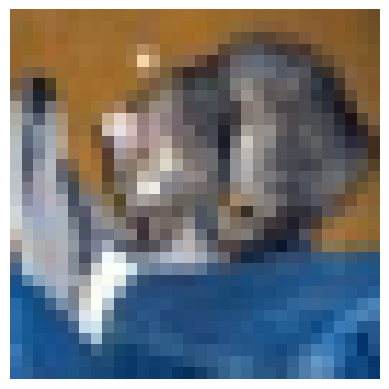

In [23]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

idx= np.random.randint(len(test_loader))
print(f'Show the image 0 of the batch {idx}. Class: ')
image = test_loader.dataset[idx][0]
image = (image- image.min())/(image.max()-image.min())
plot_figure(image)

# Accuracy


In [24]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device)
            yi = yi.to(device)
            scores = model(xi)
            # Compute the max in each row for each image of the batch
            _, preds = scores.max(1)
            num_correct += (preds == yi).sum()
            num_total += len(yi)
        return float(num_correct) / num_total

# Training Loop

In [25]:
def train(model, optimizer, epochs=100):
    model = model.to(device = device)
    for epoch in range(epochs):
        model.train()
        for (xi, yi) in train_loader:
            xi = xi.to(device = device, dtype=torch.float32)
            yi = yi.to(device = device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input=scores, target=yi.squeeze())

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        acc = accuracy(model, val_loader)
        if epoch%1 == 0:
            print(f'Epoch {epoch}, Cost: {cost.item()}, accuracy: {acc}')


# Secuential linear

In [26]:
hidden1 = 256
hidden2 = 256
lr = 1e-3
epochs = 10
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features = 3*32*32, out_features=hidden1), nn.ReLU(),
    nn.Linear(in_features = hidden1, out_features=hidden2), nn.ReLU(),
    nn.Linear(in_features = hidden2, out_features=10), nn.ReLU()
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas= (0.9, 0.999))
train(model, optimizer, epochs=epochs)

Epoch 0, Cost: 1.438110113143921, accuracy: 0.4424
Epoch 1, Cost: 1.1234761476516724, accuracy: 0.4846
Epoch 2, Cost: 1.485788106918335, accuracy: 0.5054
Epoch 3, Cost: 1.3838521242141724, accuracy: 0.5028
Epoch 4, Cost: 1.1389840841293335, accuracy: 0.5186
Epoch 5, Cost: 0.9106072783470154, accuracy: 0.5232
Epoch 6, Cost: 0.6873882412910461, accuracy: 0.5266
Epoch 7, Cost: 1.3991081714630127, accuracy: 0.5322
Epoch 8, Cost: 1.2146023511886597, accuracy: 0.522
Epoch 9, Cost: 1.295867681503296, accuracy: 0.518


# Sequetial CNN

In [27]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 1e-3

modelCNN1 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=channel1, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=16*16*channel2, out_features=10)
)

optimizer = torch.optim.Adam(modelCNN1.parameters(), lr=lr, betas= (0.9, 0.999))
train(modelCNN1, optimizer, epochs=epochs)

Epoch 0, Cost: 0.9675833582878113, accuracy: 0.6236
Epoch 1, Cost: 1.0232064723968506, accuracy: 0.6362
Epoch 2, Cost: 0.8187881708145142, accuracy: 0.6734
Epoch 3, Cost: 1.1195194721221924, accuracy: 0.673
Epoch 4, Cost: 0.7572863101959229, accuracy: 0.6772
Epoch 5, Cost: 0.5643727779388428, accuracy: 0.6778
Epoch 6, Cost: 0.6526426672935486, accuracy: 0.6714
Epoch 7, Cost: 0.9975497126579285, accuracy: 0.6636
Epoch 8, Cost: 0.4249037802219391, accuracy: 0.6628
Epoch 9, Cost: 0.33954930305480957, accuracy: 0.6562


In [28]:
acc = accuracy(modelCNN1, test_loader)
print(f'Accuracy test: {acc}')

Accuracy test: 0.6538


# OOP

In [29]:
class CNN_class1(nn.Module):
    def __init__(self, in_channels, channel1, channel2):
        super(CNN_class1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=channel1, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [30]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 1e-3

modelCNN2 = CNN_class1(in_channels=3, channel1=channel1, channel2=channel2)
optimizer = torch.optim.Adam(modelCNN2.parameters(), lr=lr, betas= (0.9, 0.999))
train(modelCNN2, optimizer, epochs=epochs)

Epoch 0, Cost: 0.6411479711532593, accuracy: 0.636
Epoch 1, Cost: 0.886730968952179, accuracy: 0.6596
Epoch 2, Cost: 1.0214401483535767, accuracy: 0.6778
Epoch 3, Cost: 1.1733015775680542, accuracy: 0.6832
Epoch 4, Cost: 0.7102988362312317, accuracy: 0.6844
Epoch 5, Cost: 0.6249756813049316, accuracy: 0.6774
Epoch 6, Cost: 0.29727068543434143, accuracy: 0.683
Epoch 7, Cost: 0.706306517124176, accuracy: 0.6658
Epoch 8, Cost: 0.5570478439331055, accuracy: 0.6604
Epoch 9, Cost: 0.6709380745887756, accuracy: 0.6688


In [31]:
acc = accuracy(modelCNN2, test_loader)
print(f'Accuracy test: {acc}')

Accuracy test: 0.6564


## A little more elegant

In [32]:
conv_k_3 = lambda channel1, channel2: nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, stride=1, padding=1)
class CNN_class1(nn.Module):
    def __init__(self, in_channels, channel1, channel2):
        super(CNN_class1, self).__init__()
        self.conv1 = conv_k_3(in_channels=in_channels, out_channels=channel1)
        self.conv2 = conv_k_3(in_channels=channel1, out_channels=channel2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x